In [1]:
##################################
# author: vedanshu
##################################

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["TF_ENABLE_WHILE_V2"]="1" 
# os.environ["TF_ENABLE_COND_V2"]="1"
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
grid_shape = (5,5) # (width, height)
image_shape=(150, 150) # (width, height) Width has to be equal to height
num_channels=3
MAX_DETECTION_IN_L2 = 10
L1_SCORE_THRESH = 0.5
L2_SCORE_THRESH = 0.1
L1_MASK_THRESH = 0.3
IS_L1_MASK = True
IS_L2_MASK = False

In [3]:
pb_fname1 = "/Users/vedanshu/frozen_graph/ved_potato_l1_sort_mask_rcnn_inception_v2.pb"
pb_fname2 = "/Users/vedanshu/frozen_graph/ved_potato_l2_5x5_sort_ssd_mobilenet_v1_fpn_3_class_oversample_BDH.pb"

In [4]:
img = cv2.imread("/Users/vedanshu/Projects/tf_research/test_images/test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [6]:
def rename_frame_name(graphdef, suffix):
    # Bug reported at https://github.com/tensorflow/tensorflow/issues/22162#issuecomment-428091121
    for n in graphdef.node:
        if "while" in n.name:
            if "frame_name" in n.attr:
                n.attr["frame_name"].s = str(n.attr["frame_name"]).replace("while_context",
                                                                           "while_context" + suffix).encode('utf-8')


In [16]:
l1_graph = tf.Graph()
with l1_graph.as_default():
    trt_graph1 = get_frozen_graph(pb_fname1)
    if IS_L1_MASK:
        [tf_input1, tf_scores1, tf_boxes1, tf_classes1, tf_num_detections1, 
        tf_masks1] = tf.import_graph_def(trt_graph1, 
                return_elements=['image_tensor:0', 'detection_scores:0', 
                'detection_boxes:0', 'detection_classes:0','num_detections:0', 
                'detection_masks:0'])
    else:
        [tf_input1, tf_scores1, tf_boxes1, tf_classes1, tf_num_detections1] = \
        tf.import_graph_def(trt_graph1, 
                return_elements=['image_tensor:0', 'detection_scores:0', 
                'detection_boxes:0', 'detection_classes:0','num_detections:0'])
        
    input1 = tf.identity(tf_input1, name="l1_input")
    # index by 0 to remove batch dimension
    boxes1 = tf.identity(tf_boxes1[0], name="l1_boxes")  
    scores1 = tf.identity(tf_scores1[0], name="l1_scores")
    classes1 = tf.identity(tf_classes1[0], name="l1_classes")
    num_detections1 = tf.identity(tf.dtypes.cast(tf_num_detections1[0], 
        tf.int32), name="l1_num_detections")
    if IS_L1_MASK:
        masks1 = tf.identity(tf_masks1[0], name="l1_masks")

In [17]:
def image_grid(input_tensor, grid_shape=(5,5), image_shape=(150, 150), 
    num_channels=3):
    # https://github.com/tensorflow/tensorflow/blob/ \
    # 23c218785eac5bfe737eec4f8081fd0ef8e0684d/tensorflow/contrib/gan/python/ \
    # eval/python/eval_utils_impl.py#L34
    height, width = grid_shape[0] * image_shape[0], grid_shape[1] * \
                    image_shape[1]
    input_tensor = tf.reshape(
      input_tensor, tuple(grid_shape) + tuple(image_shape) + (num_channels,))
    input_tensor = tf.transpose(input_tensor, [0, 1, 3, 2, 4])
    input_tensor = tf.reshape(
      input_tensor, [grid_shape[0], width, image_shape[0], num_channels])
    input_tensor = tf.transpose(input_tensor, [0, 2, 1, 3])
    input_tensor = tf.reshape(
      input_tensor, [height, width, num_channels])
    return input_tensor

def create_empty_grid():
    grid_roies = tf.zeros([1,image_shape[0]*grid_shape[0],
        image_shape[1]*grid_shape[1],num_channels], tf.uint8)
    return grid_roies, 1, tf.range(grid_shape[0]*grid_shape[1])

def get_boxes_pixels(i, k, boxes_pixels, inds_boxes_pixels, tf_input1, boxes1):
    normalizer = [tf.shape(tf_input1[0])[0], tf.shape(tf_input1[0])[1], 
                  tf.shape(tf_input1[0])[0], tf.shape(tf_input1[0])[1]]
    box = tf.multiply(boxes1[i], tf.dtypes.cast(normalizer, tf.float32))
    box = tf.dtypes.cast(tf.round(box), tf.int32)
    boxes_pixels = boxes_pixels.write(k, box)
    inds_boxes_pixels = inds_boxes_pixels.write(k, i)
    return tf.add(k, 1), boxes_pixels, inds_boxes_pixels
    
def return_null_boxes_pixels(i, k, boxes_pixels, inds_boxes_pixels, tf_input1, 
    boxes1):
    return k, boxes_pixels, inds_boxes_pixels

def while_condition1_grid(i, k, boxes_pixels, inds_boxes_pixels, tf_input1, 
    boxes1, num_detections1):
    return tf.less(i, num_detections1)

def while_condition2_grid(j, boxes_pixels, roies, tf_input1, masks1):
    return tf.less(j, tf.shape(boxes_pixels)[0])

def while_condition3_grid(k, n_iter, roies, grid_roies):
    return tf.less(k, n_iter)

def while_body1_grid(i, k, boxes_pixels, inds_boxes_pixels, tf_input1, boxes1, 
    num_detections1):
    k, boxes_pixels, inds_boxes_pixels = tf.cond(
        tf.greater_equal(scores1[i], L1_SCORE_THRESH),
        lambda: get_boxes_pixels(i, k, boxes_pixels, inds_boxes_pixels, tf_input1, 
            boxes1),
        lambda: return_null_boxes_pixels(i, k, boxes_pixels, inds_boxes_pixels, 
            tf_input1, boxes1))
    return [tf.add(i, 1), k, boxes_pixels, inds_boxes_pixels, tf_input1, boxes1,
    num_detections1]

def while_body2_grid(j, boxes_pixels, roies, tf_input1, masks1):
    startY =  boxes_pixels[j][0]
    startX =  boxes_pixels[j][1]
    endY =  boxes_pixels[j][2]
    endX =  boxes_pixels[j][3]
    boxW = endX - startX
    boxH = endY - startY
    
    if IS_L1_MASK:
        mask = masks1[j]
        mask = (mask > L1_MASK_THRESH)
        mask = tf.stack([mask, mask, mask],axis=2)
        mask = tf.cast(mask, tf.uint8)
        mask = tf.image.resize(mask, (boxH, boxW))
        roi = tf.multiply(tf_input1[0, startY:endY, startX:endX], 
            tf.cast(mask, tf.uint8))
    else:
        roi = tf_input1[0, startY:endY, startX:endX] # batch: 0
    roi = tf.image.resize_image_with_pad(roi,image_shape[0],image_shape[1])
    roi = tf.dtypes.cast(roi, tf.uint8)
    roies = roies.write(j, roi)
    return [tf.add(j, 1), boxes_pixels, roies, tf_input1, masks1]

def while_body3_grid(k, n_iter, roies, grid_roies):
    size = grid_shape[0]*grid_shape[1]
    grid_roi = image_grid(roies[size*k:size*(k+1)], grid_shape, image_shape, 
        num_channels)
    grid_roies = grid_roies.write(k, grid_roi)
    return [tf.add(k, 1), n_iter, roies, grid_roies]

def get_grid_roies(tf_input1, boxes1, num_detections1, masks1):
    i = tf.constant(0)
    k = tf.constant(0)
    boxes_pixels = tf.TensorArray(
        dtype=tf.int32,
        size=1,
        dynamic_size=True,
        clear_after_read=False, 
        name='boxes_pixels')
    inds_boxes_pixels = tf.TensorArray(
        dtype=tf.int32,
        size=1,
        dynamic_size=True,
        clear_after_read=False, 
        name='inds_boxes_pixels')

    _,_, boxes_pixels, inds_boxes_pixels, _, _, _ = tf.while_loop(
        while_condition1_grid,
        while_body1_grid,
        [i, k, boxes_pixels, inds_boxes_pixels, tf_input1, boxes1, 
        num_detections1])
    boxes_pixels = boxes_pixels.stack()
    inds_boxes_pixels = inds_boxes_pixels.stack()

    j = tf.constant(0)
    roies = tf.TensorArray(
        dtype=tf.uint8,
        size=1,
        dynamic_size=True,
        clear_after_read=False,
        infer_shape=False, 
        name='roies')

    _, _, roies, _, _ = tf.while_loop(
        while_condition2_grid,
        while_body2_grid,
        [j, boxes_pixels, roies, tf_input1, masks1])

    # Adding padding for making grid
    roies = roies.stack()
    zero_pad = tf.zeros([1, image_shape[0], image_shape[1], num_channels], 
        tf.uint8)
    _no_pad = tf.mod(tf.shape(roies)[0], 
        tf.constant(grid_shape[0]*grid_shape[1]))
    no_pad = tf.cond(tf.equal(_no_pad, tf.constant(0)), lambda: tf.constant(0), 
                     lambda: tf.subtract(
                        tf.constant(grid_shape[0]*grid_shape[1]), _no_pad))
    zero_pad = tf.tile(zero_pad, [no_pad,1,1,1])
    roies = tf.concat([roies, zero_pad], axis=0)

    # Creating batch of images of size grid_shape[0]*image_shape[0]
    size = grid_shape[0]*grid_shape[1]
    n_iter = tf.dtypes.cast(tf.shape(roies)[0]/size, tf.float32) 
    #  int32 / int32 = float64 which leads 49/49 = 0.99999999999999989

    n_iter = tf.dtypes.cast(n_iter, tf.int32)
    
    k = tf.constant(0)
    grid_roies = tf.TensorArray(
        dtype=tf.uint8,
        size=1,
        dynamic_size=True,
        clear_after_read=False,
        infer_shape=False, 
        name='grid_roies')

    _, _, _, grid_roies = tf.while_loop(
        while_condition3_grid, 
        while_body3_grid, 
        [k, n_iter, roies, grid_roies])

    grid_roies = grid_roies.stack() 

    return grid_roies, n_iter, inds_boxes_pixels

intermediate_graph = tf.Graph()
tf_sess_grid = tf.Session(graph=intermediate_graph)

with intermediate_graph.as_default():
    l1_graph_def = l1_graph.as_graph_def()
    g1name = "level1"
    rename_frame_name(l1_graph_def, g1name)
    tf.import_graph_def(l1_graph_def, name=g1name)

    tf_input1 = tf.get_default_graph().get_tensor_by_name(
        'level1/l1_input:0')
    boxes1 = tf.get_default_graph().get_tensor_by_name(
        'level1/l1_boxes:0')
    scores1 = tf.get_default_graph().get_tensor_by_name(
        'level1/l1_scores:0')
    classes1 = tf.get_default_graph().get_tensor_by_name(
        'level1/l1_classes:0')
    num_detections1 = tf.get_default_graph().get_tensor_by_name(
        'level1/l1_num_detections:0')
    if IS_L1_MASK:
        masks1 = tf.get_default_graph().get_tensor_by_name(
            'level1/l1_masks:0')
    
    _detections1 = tf.count_nonzero(tf.greater_equal(scores1, L1_SCORE_THRESH), 
        dtype=tf.int32)

    # Grid is filled along the column first
    grid_roies, batch_size, inds_boxes_pixels = tf.cond(
        tf.equal(_detections1, tf.constant(0)), 
        create_empty_grid, 
        lambda: get_grid_roies(tf_input1, boxes1, num_detections1, masks1))
    grid_roies = tf.identity(grid_roies, name="grid_roies_out")
    batch_size = tf.identity(batch_size, name="batch_size")
    
    boxes1 = tf.gather(boxes1, inds_boxes_pixels, name="l1_boxes")
    scores1 = tf.gather(scores1, inds_boxes_pixels, name="l1_scores")
    classes1 = tf.gather(classes1, inds_boxes_pixels, name="l1_classes")
    if IS_L1_MASK:
        masks1 = tf.gather(masks1, inds_boxes_pixels, name="l1_masks")
    
    tf_input1 = tf.get_default_graph().get_tensor_by_name(
        "level1/import/image_tensor:0")
    grid_roies, inds_boxes_pixels, boxes1 = tf_sess_grid.run(
        [grid_roies, inds_boxes_pixels, boxes1], {tf_input1: img[None, ...]})


In [18]:
boxes1.shape

(25, 4)

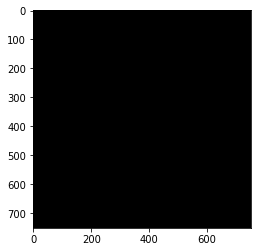

In [10]:
plt.imshow(grid_roies[0])

In [11]:
def getSquareImageFactors( img_width, img_height, target_width ):
        max_dim = tf.cond(
            img_width >= img_height, 
            lambda: img_width, 
            lambda: img_height)
        scale = target_width / max_dim
        
        def getScaledHeight(img_width, img_height, target_width, scale):
            x = 0
            img_height = tf.dtypes.cast(
                tf.dtypes.cast(img_height, tf.float64) * scale, 
                tf.int32)
            y = tf.dtypes.cast(( target_width - img_height ) / 2, tf.int32)
            return x,y
        def getScaledWidth(img_width, img_height, target_width, scale):
            y = 0
            img_width = tf.dtypes.cast(
                tf.dtypes.cast(img_width, tf.float64) * scale, 
                tf.int32)
            x = tf.dtypes.cast(( target_width - img_width ) / 2, tf.int32)
            return x,y
        
        x, y = tf.cond(
            img_width >= img_height, 
            lambda: getScaledHeight(img_width, img_height, target_width, scale),
            lambda: getScaledWidth(img_width, img_height, target_width, scale))
        
        return x, y, scale

def get_box_without_clipping(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
    arr_original_index, arr_grid_original_index):
    y = boxes_index[j][0]
    x = boxes_index[j][1]
    original_index = i*grid_shape[0]*grid_shape[1] + \
                     y*tf.constant(grid_shape[0]) + x # indexed zero
    grid_original_index = y*tf.constant(grid_shape[0]) + x
    _ymin = boxes_l2[j][0]
    _xmin = boxes_l2[j][1]
    _ymax = boxes_l2[j][2]
    _xmax = boxes_l2[j][3]

    return x, y, _ymin, _xmin, _ymax, _xmax, original_index, grid_original_index

def get_box_with_clipping(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
    arr_original_index, arr_grid_original_index):
    boxes1 = []
    for _col in range(grid_shape[0]):
        for _row in range(grid_shape[1]):
            boxes1.append([
                _row*image_shape[1], _col*image_shape[0], 
                (_row+1)*image_shape[1], (_col+1)*image_shape[0]])

    boxes1 = tf.constant(boxes1)
    # https://github.com/tensorflow/models/blob/master/research/ \
    # object_detection/core/post_processing.py#L35
    y1_min, x1_min, y1_max, x1_max = tf.split(value=boxes1, 
        num_or_size_splits=4, axis=1)
    y2_min, x2_min, y2_max, x2_max = tf.split(value=boxes_l2[j], 
        num_or_size_splits=4, axis=0)
    intersection_xmin = tf.maximum(x1_min, x2_min)
    intersection_xmax = tf.minimum(x1_max, x2_max)
    intersection_ymin = tf.maximum(y1_min, y2_min)
    intersection_ymax = tf.minimum(y1_max, y2_max)
    intersection_area = tf.maximum((intersection_xmax - intersection_xmin), 0) \
                        * tf.maximum((intersection_ymax - intersection_ymin), 0)

    area1 = (y1_max - y1_min) * (x1_max - x1_min)
    area2 = (y2_max - y2_min) * (x2_max - x2_min)

    union_area = area1 + area2  - intersection_area 
    # Adds a small epsilon to avoid divide-by-zero.
    union_area = tf.dtypes.cast(union_area, tf.float32) + 1e-8
    intersection_area = tf.dtypes.cast(intersection_area, tf.float32)

    # Calculates IoU.
    iou = intersection_area / union_area
    iou = tf.squeeze(iou)
    _iou_index_max = tf.math.argmax(iou)
    _ymin = tf.squeeze(intersection_ymin[_iou_index_max])
    _xmin = tf.squeeze(intersection_xmin[_iou_index_max])
    _ymax = tf.squeeze(intersection_ymax[_iou_index_max])
    _xmax = tf.squeeze(intersection_xmax[_iou_index_max])
     
    y = tf.dtypes.cast(_ymin/tf.constant(image_shape[0]), tf.int32)
    x = tf.dtypes.cast(_xmin/tf.constant(image_shape[1]), tf.int32)
    
    grid_original_index = y*tf.constant(grid_shape[0]) + x
    # print_op = tf.print(
    #     "index: ", grid_original_index, 
    #     "box: ", _ymin, " ", _xmin, " ", _ymax, " ", _xmax,
    #     output_stream=sys.stdout)
    # with tf.control_dependencies([print_op]):
    original_index = i*grid_shape[0]*grid_shape[1] + \
                     y*tf.constant(grid_shape[0]) + x # indexed zero

    return x, y, _ymin, _xmin, _ymax, _xmax, original_index, grid_original_index

def update_boxes(j, i, boxes_l1, boxes_l2, boxes_index, arr_boxes_l2, 
    arr_original_index, arr_grid_original_index, x, y, _ymin, _xmin, _ymax, 
    _xmax, original_index, grid_original_index):                    
    arr_original_index = arr_original_index.write(j, original_index)
    arr_grid_original_index = arr_grid_original_index.write(j, 
        grid_original_index)

    _x, _y, _scale = getSquareImageFactors(
        boxes_l1[original_index][3] - boxes_l1[original_index][1],
        boxes_l1[original_index][2] - boxes_l1[original_index][0],
        image_shape[1] )

    _x1 = tf.dtypes.cast(tf.dtypes.cast(_xmin - x*tf.constant(image_shape[0]) \
        - _x, tf.float64) / _scale, tf.int32)
    _y1 = tf.dtypes.cast(tf.dtypes.cast(_ymin - y*tf.constant(image_shape[1]) \
        - _y, tf.float64) / _scale, tf.int32)
    _y2 = tf.dtypes.cast(tf.dtypes.cast(_ymax - y*tf.constant(image_shape[1]) \
        - _y, tf.float64) / _scale, tf.int32)
    _x2 = tf.dtypes.cast(tf.dtypes.cast(_xmax - x*tf.constant(image_shape[0]) \
        - _x, tf.float64) / _scale, tf.int32)

    arr_boxes_l2 = arr_boxes_l2.write(j, [boxes_l1[original_index][0] + _y1,
                                          boxes_l1[original_index][1] + _x1,
                                          boxes_l1[original_index][0] + _y2,
                                          boxes_l1[original_index][1] + _x2])

    return [arr_boxes_l2, arr_original_index, arr_grid_original_index]

def update_with_null(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
    arr_original_index, arr_grid_original_index, x, y, _ymin, _xmin, _ymax, 
    _xmax, original_index, grid_original_index):
    arr_original_index = arr_original_index.write(j, original_index)
    arr_grid_original_index = arr_grid_original_index.write(j, 
        grid_original_index)
    arr_boxes_l2 = arr_boxes_l2.write(j,[0,0,0,0])
    return [arr_boxes_l2, arr_original_index, arr_grid_original_index]
    
def while_condition2_contour(j, i, boxes_l1, boxes_l2, scores_l2, boxes_index,
    arr_boxes_l2, arr_original_index, arr_grid_original_index):
        return tf.less(j, tf.shape(boxes_index)[0])

def while_condition1_batch(i, boxes_l1, boxes_l2, tf_scores_l2, 
    tf_classes_l2, batch_arr_original_index):
        return tf.less(i, tf_batch_size)

def while_body2_contour(j, i, boxes_l1, boxes_l2, scores_l2, boxes_index, 
    arr_boxes_l2, arr_original_index, arr_grid_original_index):
    x, y, _ymin, _xmin, _ymax, _xmax, original_index, grid_original_index = \
    tf.cond(
        tf.math.logical_and(
            tf.math.equal(boxes_index[j][0],boxes_index[j][2]),
            tf.math.equal(boxes_index[j][1],boxes_index[j][3])
        ),
    lambda: get_box_without_clipping(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
        arr_original_index, arr_grid_original_index),
    lambda: get_box_with_clipping(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
        arr_original_index, arr_grid_original_index),
    )

    arr_boxes_l2, arr_original_index, arr_grid_original_index = tf.cond(
        tf.math.logical_and(tf.math.less(original_index, tf.shape(boxes_l1)[0]),
                            tf.greater_equal(scores_l2[j], L2_SCORE_THRESH),
                           ),
        lambda: update_boxes(j, i, boxes_l1, boxes_l2, boxes_index, arr_boxes_l2, 
            arr_original_index, arr_grid_original_index,
            x, y, _ymin, _xmin, _ymax, _xmax, original_index, 
            grid_original_index), 
        lambda: update_with_null(j, i, boxes_l2, boxes_index, arr_boxes_l2, 
            arr_original_index, arr_grid_original_index,
            x, y, _ymin, _xmin, _ymax, _xmax, original_index, 
            grid_original_index),
        name='if_cond_update')
    return [tf.add(j, 1), i, boxes_l1, boxes_l2, scores_l2, boxes_index, 
    arr_boxes_l2, arr_original_index, arr_grid_original_index]

def while_body1_batch(i, boxes_l1, tf_boxes_l2, tf_scores_l2, tf_classes_l2, 
    batch_arr_original_index):
        boxes_l2 = tf_boxes[i]
        scores_l2 = tf_scores[i]
        classes_l2 = tf_classes[i]
        num_detections_l2 = tf.dtypes.cast(tf_num_detections[i], tf.int32)
        
        grid_height = image_shape[0]*grid_shape[0]
        grid_width = image_shape[1]*grid_shape[1]
        boxes_l2 = boxes_l2 * tf.dtypes.cast(tf.constant([grid_height, 
            grid_width, grid_height, grid_width]), tf.float32)
        boxes_index = boxes_l2/tf.dtypes.cast(tf.constant(image_shape[0]), 
            tf.float32)
        boxes_index = tf.dtypes.cast(boxes_index, tf.int32)
        boxes_l2 = tf.dtypes.cast(boxes_l2, tf.int32)

        j = tf.constant(0)
        arr_boxes_l2 = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,
            clear_after_read=False)
        arr_original_index = tf.TensorArray(dtype=tf.int32,size=1, 
            dynamic_size=True,clear_after_read=False)
        arr_grid_original_index = tf.TensorArray(dtype=tf.int32,size=1, 
            dynamic_size=True,clear_after_read=False)

        j, _, _, _, _, _, arr_boxes_l2, \
        arr_original_index, arr_grid_original_index = \
        tf.while_loop(while_condition2_contour, 
            while_body2_contour,
            [j, i, boxes_l1, boxes_l2, scores_l2, boxes_index, arr_boxes_l2, 
            arr_original_index, arr_grid_original_index],
            name='while_over_l2_boxes_index')

        boxes_l2 = arr_boxes_l2.stack()
        original_index = arr_original_index.stack()
        grid_original_index = arr_grid_original_index.stack()
        
        inds = tf.argsort(grid_original_index,axis=-1,direction='ASCENDING',
            stable=False,name=None)
        boxes_l2 = tf.gather(boxes_l2, inds)
        grid_original_index = tf.gather(grid_original_index, inds)
        original_index = tf.gather(original_index, inds)
        scores_l2 = tf.gather(scores_l2, inds)
        classes_l2 = tf.gather(classes_l2, inds)
        
        grid_original_index, idx = tf.unique(grid_original_index)
        original_index, _ = tf.unique(original_index)
        
        partitioned_boxes_l2 = tf.dynamic_partition(boxes_l2, idx, 
            grid_shape[0]*grid_shape[1])
        partitioned_scores_l2 = tf.dynamic_partition(scores_l2, idx, 
            grid_shape[0]*grid_shape[1])
        partitioned_classes_l2 = tf.dynamic_partition(classes_l2, idx, 
            grid_shape[0]*grid_shape[1])
        
        _x = tf.constant(grid_shape[0]*grid_shape[1]) - \
             tf.shape(original_index)[0]
        _r = tf.cond(tf.less(_x, 0), lambda: tf.constant(0), 
            lambda: tf.identity(_x))
        pad = tf.tile([tf_batch_size*grid_shape[0]*grid_shape[1]], [_r]) 
        # the last index (tf_batch_size*grid_shape[0]*grid_shape[1]) will be 
        # excluded during scatter_nd

        original_index = tf.concat([original_index,pad], 0)

        for u in range(len(partitioned_boxes_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - \
                 tf.shape(partitioned_boxes_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), 
                lambda: tf.constant(0), 
                lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1,4], tf.int32), [_r, 1])
            partitioned_boxes_l2[u] = tf.concat(
                [partitioned_boxes_l2[u][:MAX_DETECTION_IN_L2],pad], 0)

        for u in range(len(partitioned_scores_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - \
                 tf.shape(partitioned_scores_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), 
                lambda: tf.constant(0), 
                lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1], tf.float32), [_r])
            partitioned_scores_l2[u] = tf.concat(
                [partitioned_scores_l2[u][:MAX_DETECTION_IN_L2],pad], 0)
            
        for u in range(len(partitioned_classes_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - \
                 tf.shape(partitioned_classes_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), 
                lambda: tf.constant(0), 
                lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1], tf.float32), [_r])
            partitioned_classes_l2[u] = tf.concat(
                [partitioned_classes_l2[u][:MAX_DETECTION_IN_L2],pad], 0)

        partitioned_boxes_l2 = tf.convert_to_tensor(partitioned_boxes_l2)
        partitioned_scores_l2 = tf.convert_to_tensor(partitioned_scores_l2)
        partitioned_classes_l2 = tf.convert_to_tensor(partitioned_classes_l2)
        
        batch_arr_original_index = batch_arr_original_index.write(i, 
            original_index)
        tf_boxes_l2 = tf_boxes_l2.write(i, partitioned_boxes_l2)
        tf_scores_l2 = tf_scores_l2.write(i, partitioned_scores_l2)
        tf_classes_l2 = tf_classes_l2.write(i, partitioned_classes_l2)
        
        return [tf.add(i, 1), boxes_l1, tf_boxes_l2, tf_scores_l2, 
        tf_classes_l2, batch_arr_original_index]

connected_graph = tf.Graph()
tf_sess_main = tf.Session(graph=connected_graph)

with connected_graph.as_default():
    intermediate_graph_def = intermediate_graph.as_graph_def()
    g1name = 'ved'
    rename_frame_name(intermediate_graph_def, g1name)
    tf.import_graph_def(intermediate_graph_def, name=g1name)
    
    tf_input = tf.get_default_graph().get_tensor_by_name(
        'ved/level1/import/image_tensor:0')
    tf_grid_out = tf.get_default_graph().get_tensor_by_name(
        'ved/grid_roies_out:0')
    tf_batch_size = tf.get_default_graph().get_tensor_by_name(
        'ved/batch_size:0')
    tf_num_detections_l1 = tf.dtypes.cast(
        tf.get_default_graph().get_tensor_by_name(
            'ved/level1/import/num_detections:0'), tf.int32)
    tf_boxes_l1 = tf.get_default_graph().get_tensor_by_name(
        'ved/l1_boxes:0')
    tf_scores_l1 = tf.get_default_graph().get_tensor_by_name(
        'ved/l1_scores:0')
    tf_classes_l1 = tf.get_default_graph().get_tensor_by_name(
        'ved/l1_classes:0')
    if IS_L1_MASK:
        tf_masks_l1 = tf.get_default_graph().get_tensor_by_name(
            'ved/l1_masks:0')
    
    trt_graph2 = get_frozen_graph(pb_fname2)
    g2name = 'level2'
    rename_frame_name(trt_graph2, g2name)
    [tf_scores, tf_boxes, tf_classes, tf_num_detections] = tf.import_graph_def(
        trt_graph2,
        input_map={'image_tensor': tf_grid_out},
        return_elements=['detection_scores:0', 'detection_boxes:0', 
        'detection_classes:0','num_detections:0'])    
    
    # Only for debugging
    grid_boxes_l2, grid_scores_l2, grid_img  = tf_sess_main.run(
        [tf_boxes, tf_scores, tf_grid_out], {tf_input: img[None, ...]})
    
    ip_image_height = tf.shape(tf_input[0])[0]
    ip_image_width = tf.shape(tf_input[0])[1]
    boxes_l1 = tf_boxes_l1 * tf.dtypes.cast(
        [ip_image_height, ip_image_width, ip_image_height, ip_image_width], 
        tf.float32)
    boxes_l1 = tf.dtypes.cast(boxes_l1, tf.int32)
    tf_boxes_l1 = tf.identity(boxes_l1)
#     tf_boxes_l1 = tf.expand_dims(boxes_l1, 0)
    
    i = tf.constant(0)
    tf_boxes_l2 = tf.TensorArray(dtype=tf.int32,size=1,dynamic_size=True,
        clear_after_read=False, name='tf_arr_boxes_l2')
    tf_scores_l2 = tf.TensorArray(dtype=tf.float32,size=1,dynamic_size=True,
        clear_after_read=False, name='tf_arr_scores_l2')
    tf_classes_l2 = tf.TensorArray(dtype=tf.float32,size=1,dynamic_size=True,
        clear_after_read=False, name='tf_arr_classes_l2')
    batch_arr_original_index = tf.TensorArray(dtype=tf.int32,size=1, 
        dynamic_size=True,clear_after_read=False)

    _, _, tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index = \
    tf.while_loop(while_condition1_batch,while_body1_batch,
        [i, boxes_l1, tf_boxes_l2, tf_scores_l2, tf_classes_l2, 
        batch_arr_original_index],
        name='while_over_batch_size')
    
    tf_boxes_l2 = tf_boxes_l2.stack()
    tf_scores_l2 = tf_scores_l2.stack()
    tf_classes_l2 = tf_classes_l2.stack()
    batch_arr_original_index = batch_arr_original_index.stack()
       
    tf_original_index_l2 = tf.squeeze(batch_arr_original_index, 
        name="original_index_l2")
    
    tf_boxes_l2 = tf.reshape(tf_boxes_l2, [-1,MAX_DETECTION_IN_L2,4])
    tf_scores_l2 = tf.reshape(tf_scores_l2, [-1, MAX_DETECTION_IN_L2])
    tf_classes_l2 = tf.reshape(tf_classes_l2, [-1, MAX_DETECTION_IN_L2])
    
    tf_boxes_l1 = tf.identity(tf_boxes_l1, name="detection_boxes_l1")
    tf_scores_l1 = tf.identity(tf_scores_l1, name="detection_scores_l1")
    tf_classes_l1 = tf.identity(tf_classes_l1, name="detection_classes_l1")
    if IS_L1_MASK:
        tf_masks_l1 = tf.identity(tf_masks_l1, name="detection_masks_l1")
    
    _indices = tf.reshape(tf_original_index_l2, [-1]) 
    _indices = tf.expand_dims(_indices, 1)
    
    _shape_boxes_l2 = [tf_batch_size*grid_shape[0]*grid_shape[1] + 1, 
                       MAX_DETECTION_IN_L2, 4]
    tf_boxes_l2 = tf.scatter_nd(_indices, tf_boxes_l2, _shape_boxes_l2, 
        name="detection_boxes_l2_scatter_nd")
    tf_boxes_l2 = tf_boxes_l2[:tf.shape(tf_boxes_l1)[0]]
    tf_boxes_l2 = tf.identity(tf_boxes_l2, name="detection_boxes_l2")
    
    _shape_scores_l2 = [tf_batch_size*grid_shape[0]*grid_shape[1] + 1, 
                        MAX_DETECTION_IN_L2]     
    tf_scores_l2 = tf.scatter_nd(_indices, tf_scores_l2, _shape_scores_l2, 
        name="detection_scores_l2_scatter_nd")
    tf_scores_l2 = tf_scores_l2[:tf.shape(tf_boxes_l1)[0]]
    tf_scores_l2 = tf.identity(tf_scores_l2, name="detection_scores_l2")
    
    _shape_classes_l2 = [tf_batch_size*grid_shape[0]*grid_shape[1] + 1, 
                         MAX_DETECTION_IN_L2]
    tf_classes_l2 = tf.scatter_nd(_indices, tf_classes_l2, _shape_classes_l2, 
        name="detection_classes_l2_scatter_nd")
    tf_classes_l2 = tf_classes_l2[:tf.shape(tf_boxes_l1)[0]]
    tf_classes_l2 = tf.identity(tf_classes_l2, name="detection_classes_l2")
    
    tf_max_num_detection = tf.identity(tf.shape(tf_boxes_l1)[0], 
        name="max_num_detections")
                
out_boxes_l1, out_scores_l1, out_classes_l1, out_boxes_l2, out_scores_l2, \
out_classes_l2, _indices  = tf_sess_main.run([tf_boxes_l1, tf_scores_l1, 
    tf_classes_l1, tf_boxes_l2, tf_scores_l2, tf_classes_l2, _indices],
    {tf_input: img[None, ...]})
    

In [12]:
out_boxes_l2.shape

(25, 10, 4)

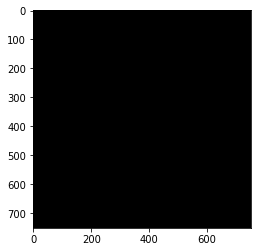

In [13]:
for b in range(grid_img.shape[0]):
    _img_out = grid_img[b].copy()
    grid_size = image_shape[0]*grid_shape[0]

    _grid_boxes_l2 = grid_boxes_l2[b]
    _grid_boxes_l2 = _grid_boxes_l2* np.array([grid_size, grid_size, grid_size, grid_size])
    _grid_boxes_l2 = _grid_boxes_l2.astype(int)

    for i in range(_grid_boxes_l2.shape[0]):
        if grid_scores_l2[b][i] > L2_SCORE_THRESH:
            startY, startX, endY, endX = _grid_boxes_l2[i]
            cv2.rectangle(_img_out, (startX, startY),(endX, endY), (0, 255, 0), 2)
            cv2.putText(_img_out, str(i), (startX, endY), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    plt.imshow(_img_out)
    image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
    cv2.imwrite(str(b)+'out_grid_l2.jpg', image)

True

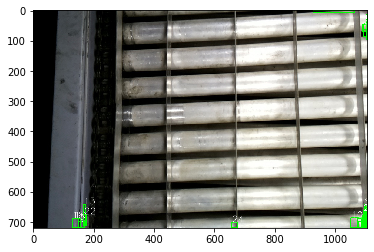

In [14]:
_img_out = img.copy()
for j in range(out_boxes_l1.shape[0]):
    startY_l1, startX_l1, endY_l1, endX_l1 = out_boxes_l1[j]
    cv2.rectangle(_img_out, (startX_l1, startY_l1),
                  (endX_l1, endY_l1), (0, 255, 0), 2)
    cv2.putText(_img_out, str(j), (startX_l1, startY_l1), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_l1.jpg', image)

True

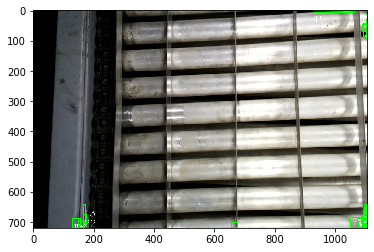

In [15]:
_img_out = img.copy()

for j in range(out_boxes_l1.shape[0]):
    startY_l1, startX_l1, endY_l1, endX_l1 = out_boxes_l1[j]
    cv2.rectangle(_img_out, (startX_l1, startY_l1),
                  (endX_l1, endY_l1), (0, 255, 0), 2)
    cv2.putText(_img_out, str(j), (startX_l1, startY_l1+40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    for i in range(out_boxes_l2.shape[1]):
        if out_scores_l2[j][i] > L2_SCORE_THRESH:
            startY_l2, startX_l2, endY_l2, endX_l2 = out_boxes_l2[j][i]
            cv2.rectangle(_img_out, (startX_l2, startY_l2),
                          (endX_l2, endY_l2), (255, 0, 0), 2)
            cv2.putText(_img_out, str(j), (startX_l2, endY_l2), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), lineType=cv2.LINE_AA)
        
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_with_l2.jpg', image)

In [ ]:
out_boxes_l1.shape[0]

In [ ]:
import os
import shutil

with connected_graph.as_default():
    print('\nSaving...')
    cwd = os.getcwd()
    path = os.path.join(cwd, 'saved_model')
    shutil.rmtree(path, ignore_errors=True)
    inputs_dict = {
        "image_tensor": tf_input
    }
    if IS_L1_MASK:
        outputs_dict = {
            "detection_boxes_l1": tf_boxes_l1,
            "detection_scores_l1": tf_scores_l1,
            "detection_classes_l1": tf_classes_l1,
            "detection_masks_l1": tf_masks_l1,
            "max_num_detection": tf_max_num_detection,
            "detection_boxes_l2": tf_boxes_l2,
            "detection_scores_l2": tf_scores_l2,
            "detection_classes_l2": tf_classes_l2
        }
    else:
        outputs_dict = {
            "detection_boxes_l1": tf_boxes_l1,
            "detection_scores_l1": tf_scores_l1,
            "detection_classes_l1": tf_classes_l1,
            "max_num_detection": tf_max_num_detection,
            "detection_boxes_l2": tf_boxes_l2,
            "detection_scores_l2": tf_scores_l2,
            "detection_classes_l2": tf_classes_l2
        }
    tf.saved_model.simple_save(
        tf_sess_main, path, inputs_dict, outputs_dict
    )
    print('Ok')

# Code from here is only for debugging 

In [ ]:
# IOU logic 
#https://github.com/tensorflow/models/blob/master/research/object_detection/core/post_processing.py#L35
boxes1 = np.array([[16,16,32,32],[32,32,64,64],[4,4,8,8],[8,8,16,16]])
boxes2 = np.array([2,2,6,6])
tf_boxes1 = tf.constant(boxes1)
tf_boxes2 = tf.constant(boxes2)
print(boxes1)
print(boxes2)

y1_min, x1_min, y1_max, x1_max = tf.split(value=boxes1, num_or_size_splits=4, axis=1)
y2_min, x2_min, y2_max, x2_max = tf.split(value=boxes2, num_or_size_splits=4, axis=0)
intersection_xmin = tf.maximum(x1_min, x2_min)
intersection_xmax = tf.minimum(x1_max, x2_max)
intersection_ymin = tf.maximum(y1_min, y2_min)
intersection_ymax = tf.minimum(y1_max, y2_max)
intersection_area = tf.maximum((intersection_xmax - intersection_xmin), 0) * tf.maximum(
        (intersection_ymax - intersection_ymin), 0)

area1 = (y1_max - y1_min) * (x1_max - x1_min)
area2 = (y2_max - y2_min) * (x2_max - x2_min)

union_area = area1 + area2  - intersection_area 
# Adds a small epsilon to avoid divide-by-zero.
union_area = tf.dtypes.cast(union_area, tf.float32) + 1e-8
intersection_area = tf.dtypes.cast(intersection_area, tf.float32)

# Calculates IoU.
iou = intersection_area / union_area
iou = tf.squeeze(iou)
_iou_index_max = tf.math.argmax(iou)
_ymin = tf.squeeze(intersection_ymin[_iou_index_max])
_xmin = tf.squeeze(intersection_xmin[_iou_index_max])
_ymax = tf.squeeze(intersection_ymax[_iou_index_max])
_xmax = tf.squeeze(intersection_xmax[_iou_index_max])
                   
with tf.Session() as sess:
    print(sess.run([_ymin,_xmin,_ymax,_xmax]))


In [ ]:
grid_shape = (5,5) # (width, height)
image_shape=(150, 150) # (width, height) Width has to be equal to height

        
        

In [ ]:
_ref_boxes